# Data Input

In [ ]:
from urllib.request import urlretrieve
import shutil

url = "https://s3.amazonaws.com/tripdata/202401-citibike-tripdata.zip"
urlretrieve(url, "202401-citibike-tripdata.zip") # Download dataset
shutil.unpack_archive("202401-citibike-tripdata.zip", "202401-citibike-tripdata") # Unzip dataset

In [ ]:
import pandas as pd
import os

csv_dir = "/content/202401-citibike-tripdata/"
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]
dfs = []

for csv_file in csv_files:
    file_path = os.path.join(csv_dir, csv_file)
    df_temp = pd.read_csv(file_path, dtype={
    "start_station_id": "string",
    "end_station_id": "string"
}, parse_dates=["started_at", "ended_at"])  # convert station ids to string for now
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True) # combine the 2 csv files
print(df.head())
print(f"\nShape of the combined DataFrame: {df.shape}")

            ride_id  rideable_type              started_at  \
0  62EF1AC5BE598131   classic_bike 2024-01-24 09:03:33.533   
1  8464E543DAB27DBF   classic_bike 2024-01-30 08:21:29.510   
2  9C04FDC8549F5205  electric_bike 2024-01-22 21:18:25.199   
3  7DD1703A3E0D8833  electric_bike 2024-01-31 22:15:49.861   
4  6A96FCD170996E59   classic_bike 2024-01-29 22:52:28.276   

                 ended_at         start_station_name start_station_id  \
0 2024-01-24 09:06:53.535           E 102 St & 1 Ave          7407.13   
1 2024-01-30 08:29:03.304           E 102 St & 1 Ave          7407.13   
2 2024-01-22 21:26:24.647            W 35 St & 8 Ave          6526.01   
3 2024-01-31 22:22:45.520  Warren St & Roosevelt Ave          6346.07   
4 2024-01-29 22:57:05.099            6 Ave & W 33 St          6364.07   

           end_station_name end_station_id  start_lat  start_lng    end_lat  \
0  E 103 St & Lexington Ave        7463.09  40.786995 -73.941648  40.790305   
1           E 91 St & 2 Ave   

# Data Preprocessing

In [ ]:
mask_start = ~df["start_station_id"].str.replace(".", "", regex=False).str.isnumeric()
mask_end = ~df["end_station_id"].str.replace(".", "", regex=False).str.isnumeric() # Find non-numeric station ids
mask = mask_start | mask_end
print(f"Found {mask.sum()} rows with non-numeric station IDs")
df.loc[mask, ["start_station_id", "end_station_id"]].head()

Found 337 rows with non-numeric station IDs


,start_station_id,end_station_id
29386,SYS016,4768.02
52517,6740.10,HB610
55975,6740.10,HB610
67218,SYS016,5170.01
68710,6432.11,JC035


In [ ]:
df = df[~mask].copy() # Remove the station ids
df["start_station_id"] = df["start_station_id"].astype(float)
df["end_station_id"] = df["end_station_id"].astype(float) # Convert station ids to float

In [ ]:
na_station_ids_df = df[df['start_station_id'].isna() | df['end_station_id'].isna()]
print(f"Number of rows with N/A station IDs: {len(na_station_ids_df)}")
df = df.dropna(subset=['start_station_id', 'end_station_id'])

Number of rows with N/A station IDs: 0


# Data Visualization

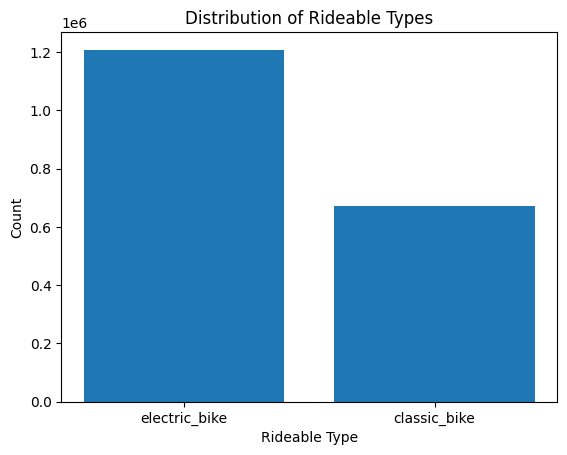

In [ ]:
import matplotlib.pyplot as plt

rideable_type_counts = df["rideable_type"].value_counts()

plt.bar(rideable_type_counts.index, rideable_type_counts.values)
plt.xlabel("Rideable Type")
plt.ylabel("Count")
plt.title("Distribution of Rideable Types")
plt.show()

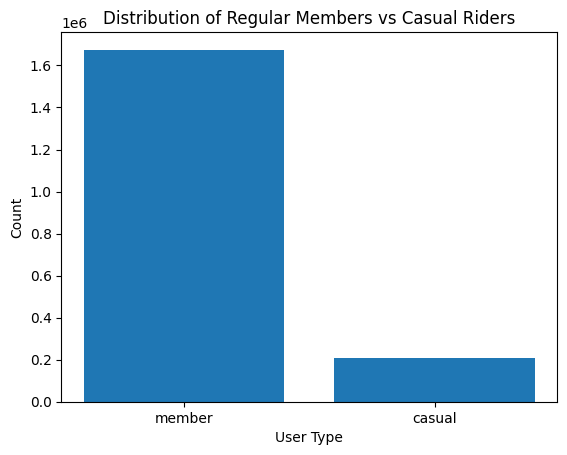

In [ ]:
user_type_counts = df["member_casual"].value_counts()

plt.bar(user_type_counts.index, user_type_counts.values)
plt.xlabel("User Type")
plt.ylabel("Count")
plt.title("Distribution of Regular Members vs Casual Riders")
plt.show()

In [ ]:
start_station_counts = df["start_station_id"].value_counts()
end_station_counts = df["end_station_id"].value_counts()
start_station_df = start_station_counts.reset_index()
start_station_df.columns = ["station_id", "start_count"]

end_station_df = end_station_counts.reset_index()
end_station_df.columns = ["station_id", "end_count"]

station_counts_df = pd.merge(start_station_df, end_station_df, on="station_id", how="outer").fillna(0)
station_counts_df.head()

,station_id,start_count,end_count
0,2733.03,64.0,69
1,2782.02,102.0,97
2,2821.05,156.0,167
3,2832.03,119.0,124
4,2861.02,113.0,100


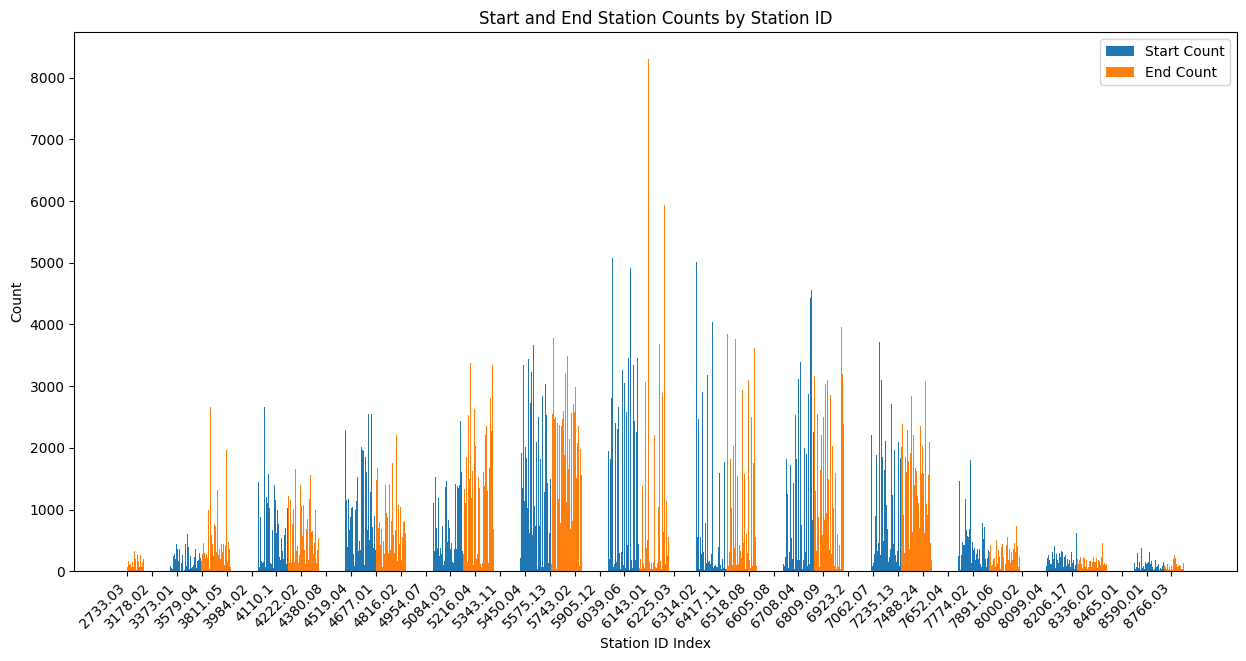

In [ ]:
import numpy as np

n_stations = len(station_counts_df)
bar_width = 0.35
index = np.arange(n_stations)

plt.figure(figsize=(15, 7))
plt.bar(index, station_counts_df["start_count"], bar_width, label="Start Count")
plt.bar(index + bar_width, station_counts_df["end_count"], bar_width, label="End Count")

plt.xlabel("Station ID Index")
plt.ylabel("Count")
plt.title("Start and End Station Counts by Station ID")
plt.xticks(index[::50], station_counts_df["station_id"][::50], rotation=45, ha='right')
plt.legend()
plt.show()

In [ ]:
stations_with_high_start_count = station_counts_df[station_counts_df["start_count"] > 6000]
print("Station(s) with start_count > 6000:")
display(stations_with_high_start_count)

Station(s) with start_count > 6000:


,station_id,start_count,end_count
1048,6140.05,8320.0,8309
1162,6331.01,6020.0,6051
1218,6450.05,6325.0,6364
1407,6822.09,6554.0,6615


In [ ]:
print(df.head)

<bound method NDFrame.head of                   ride_id  rideable_type              started_at  \
0        62EF1AC5BE598131   classic_bike 2024-01-24 09:03:33.533   
1        8464E543DAB27DBF   classic_bike 2024-01-30 08:21:29.510   
2        9C04FDC8549F5205  electric_bike 2024-01-22 21:18:25.199   
3        7DD1703A3E0D8833  electric_bike 2024-01-31 22:15:49.861   
4        6A96FCD170996E59   classic_bike 2024-01-29 22:52:28.276   
...                   ...            ...                     ...   
1888080  53C5A7DDC930FE68  electric_bike 2024-01-19 08:11:31.812   
1888081  80C14103C204CD47  electric_bike 2024-01-23 08:50:57.782   
1888082  E1EE9037A8CB6101  electric_bike 2024-01-21 14:16:24.984   
1888083  DA5E681B117190A0  electric_bike 2024-01-23 09:02:49.848   
1888084  C29B38D0D93E10BA   classic_bike 2024-01-26 09:39:15.238   

                       ended_at         start_station_name  start_station_id  \
0       2024-01-24 09:06:53.535           E 102 St & 1 Ave           7407

 ML MODEL -> station popularity/busyness :

In [ ]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['hour'] = df['started_at'].dt.hour
df['day_of_month'] = df['started_at'].dt.day

In [ ]:
station_busyness = df.groupby(
    ['start_station_name', 'day_of_month', 'hour']
).size().reset_index(name='ride_count')

In [ ]:
print(station_busyness.drop_duplicates(subset=['start_station_name']).head(20))

     start_station_name  day_of_month  hour  ride_count
0      1 Ave & E 110 St             1     6           2
480     1 Ave & E 16 St             1     0           3
1097    1 Ave & E 18 St             1     0           1
1697    1 Ave & E 30 St             1     0           5
2302    1 Ave & E 39 St             1     1           2
2885    1 Ave & E 44 St             1     0           1
3321     1 Ave & E 6 St             1     0           5
3880    1 Ave & E 62 St             1     1           2
4510    1 Ave & E 68 St             1     0           1
5145    1 Ave & E 94 St             1     0           1
5577  1 Pl & Clinton St             1     1           4
5981       1 St & 6 Ave             1     2           4
6399   10 Ave & W 14 St             1     0           1
6840  10 Ave & W 202 St             1     1           1
6913  10 Ave & W 204 St             2    18           1
6940  10 Ave & W 207 St             1    17           1
7048  10 Ave & W 215 St             1    14     

In [ ]:
from sklearn.preprocessing import LabelEncoder
le_station = LabelEncoder()
station_busyness['station_id'] = le_station.fit_transform(station_busyness['start_station_name'])
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [ ]:
x = station_busyness[['day_of_month', 'hour', 'station_id']]
y = station_busyness['ride_count']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [ ]:
print("Training set x: ",x_train)
print("Training set y: ",y_train)

Training set x:          day_of_month  hour  station_id
223560            30    18         891
303580            16    15        1113
209188            13    19         836
409591             1     0        1484
296425            20    13        1095
...              ...   ...         ...
359783             8    18        1315
152315             4    22         640
117952            11     6         518
435829             2    16        1567
305711            11     9        1121

[454158 rows x 3 columns]
Training set y:  223560    2
303580    1
209188    1
409591    2
296425    5
         ..
359783    3
152315    2
117952    1
435829    1
305711    2
Name: ride_count, Length: 454158, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_bikedemand = RandomForestRegressor(n_estimators=200, random_state=0)
model_bikedemand.fit(x_train, y_train)

RandomForestRegressor(random_state=0)

In [ ]:
import joblib
joblib.dump(model_bikedemand, 'bike_demand_model.pkl')
joblib.dump(le_station, 'le_station.pkl')
print(" Both Model and encoder saved for using in 2025 dataset")


 Both Model and encoder saved for using in 2025 dataset


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_predict = model_bikedemand.predict(x_test)
mean_absolute_percentage_error_score = mean_absolute_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)
mean_squared_error_score = mean_squared_error(y_test, y_predict)
print("mae score(in%):",mean_absolute_percentage_error_score)
print("r2 score:",r2)
print("mse score:",mean_squared_error_score)

mae score(in%): 1.3790934492393663
r2 score: 0.6025020602922706
mse score: 4.639561128762708


time to validate how well the model is working

In [ ]:
predict_station = "W 21 St & 6 Ave"
predict_day = 20          # shows the day of the month
predict_hour = 11         # hour of the day (0–23)

predict_station_id = le_station.transform([predict_station])[0]
real_station_id = df[df['start_station_name'] == predict_station]['start_station_id'].iloc[0]

input_data = pd.DataFrame({
    'day_of_month': [predict_day],
    'hour': [predict_hour],
    'station_id': [predict_station_id]
})

In [ ]:
predicted_ride_count = model_bikedemand.predict(input_data)

In [ ]:
actual_ride_count = station_busyness[
    (station_busyness['start_station_name'] == predict_station) &
    (station_busyness['day_of_month'] == predict_day) &
    (station_busyness['hour'] == predict_hour)
]['ride_count'].values

In [ ]:
predicted_ride_count = model_bikedemand.predict(input_data)
print(f"Predicted number of bikes rented at '{predict_station}' on day {predict_day} at hour {predict_hour}: {predicted_ride_count[0]:.2f}")
print(f"Actual number of bikes rented at '{predict_station}' on {predict_day} at {predict_hour}:00: {actual_ride_count[0]}")
print(f"Station ID for '{predict_station}': {predict_station_id}")
print(f"Real Station ID for '{predict_station}': {real_station_id}")

Predicted number of bikes rented at 'W 21 St & 6 Ave' on day 20 at hour 11: 14.21
Actual number of bikes rented at 'W 21 St & 6 Ave' on 20 at 11:00: 16
Station ID for 'W 21 St & 6 Ave': 1938
Real Station ID for 'W 21 St & 6 Ave': 6140.05


2025 Jan

In [ ]:
from urllib.request import urlretrieve
import shutil

url = "https://s3.amazonaws.com/tripdata/202501-citibike-tripdata.zip"
urlretrieve(url, "202501-citibike-tripdata.zip") # Download dataset
shutil.unpack_archive("202501-citibike-tripdata.zip", "202501-citibike-tripdata") # Unzip dataset

In [ ]:
import pandas as pd
import os

csv_dir = "/content/202501-citibike-tripdata/"
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]
dfs = []

for csv_file in csv_files:
    file_path = os.path.join(csv_dir, csv_file)
    df_temp = pd.read_csv(file_path, dtype={
    "start_station_id": "string",
    "end_station_id": "string"
}, parse_dates=["started_at", "ended_at"])  # convert station ids to string for now
    dfs.append(df_temp)

jan_df = pd.concat(dfs, ignore_index=True) # combine the 2 csv files
print(jan_df.head())
print(jan_df.shape)

            ride_id  rideable_type              started_at  \
0  44001153A1291415  electric_bike 2025-01-15 20:21:30.116   
1  29A89672D7BEFFD5  electric_bike 2025-01-24 13:06:57.377   
2  2CA4DFEBDCE7E925   classic_bike 2025-01-31 07:07:21.473   
3  49388F1F48DD1693   classic_bike 2025-01-24 17:19:44.412   
4  AF222F8FAE2CFC02  electric_bike 2025-01-25 12:02:15.011   

                 ended_at        start_station_name start_station_id  \
0 2025-01-15 20:34:16.182    Ash St & Manhattan Ave          6019.04   
1 2025-01-24 13:26:37.168     Allen St & Stanton St          5484.09   
2 2025-01-31 07:10:01.536     Carlton Ave & Dean St          4199.12   
3 2025-01-24 17:28:25.872            31 Ave & 30 St          6857.09   
4 2025-01-25 12:14:09.748  Central Park W & W 91 St          7453.01   

                end_station_name end_station_id  start_lat  start_lng  \
0                      Motorgate        6814.01  40.738095 -73.954867   
1  Atlantic Ave & Fort Greene Pl        4354.07 

In [ ]:
import joblib

model_path = '/content/bike_demand_model.pkl'
model_jan = joblib.load(model_path)

In [ ]:
import pandas as pd
jan_df['started_at'] = pd.to_datetime(jan_df['started_at'])
jan_df['hour'] = jan_df['started_at'].dt.hour
jan_df['day_of_month'] = jan_df['started_at'].dt.day

In [ ]:

jan_station_busy = jan_df.groupby(['start_station_name', 'day_of_month', 'hour']).size().reset_index(name='ride_count')


In [ ]:
from sklearn.preprocessing import LabelEncoder

le_station = LabelEncoder()
jan_station_busy['station_id'] = le_station.fit_transform(jan_station_busy['start_station_name'])


In [ ]:
x_jan = jan_station_busy[['day_of_month', 'hour', 'station_id']]
y_jan = jan_station_busy['ride_count']

In [ ]:
y_pred_jan = model_jan.predict(x_jan)

In [ ]:
predict_station = "W 21 St & 6 Ave"
predict_day = 20          # shows the day of the month
predict_hour = 11         # hour of the day (0–23)

predict_station_id = le_station.transform([predict_station])[0]
real_station_id = jan_df[jan_df['start_station_name'] == predict_station]['start_station_id'].iloc[0]

input_data_jan = pd.DataFrame({
    'day_of_month': [predict_day],
    'hour': [predict_hour],
    'station_id': [predict_station_id]
})

In [ ]:
predicted_ride_count_jan = model_jan.predict(input_data_jan)

In [ ]:
actual_ride_count = jan_station_busy[
    (jan_station_busy['start_station_name'] == predict_station) &
    (jan_station_busy['day_of_month'] == predict_day) &
    (jan_station_busy['hour'] == predict_hour)
]['ride_count'].values

In [ ]:
predicted_ride_count = model_jan.predict(input_data_jan)
print(f"Predicted number of bikes rented at '{predict_station}' on day {predict_day} at hour {predict_hour}: {predicted_ride_count_jan [0]:.2f}")
print(f"Actual number of bikes rented at '{predict_station}' on {predict_day} at {predict_hour}:00: {actual_ride_count[0]}")
print(f"Station ID for '{predict_station}': {predict_station_id}")
print(f"Real Station ID for '{predict_station}': {real_station_id}")

Predicted number of bikes rented at 'W 21 St & 6 Ave' on day 20 at hour 11: 5.10
Actual number of bikes rented at 'W 21 St & 6 Ave' on 20 at 11:00: 14
Station ID for 'W 21 St & 6 Ave': 1972
Real Station ID for 'W 21 St & 6 Ave': 6140.05


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_predict = model_jan.predict(x_jan)
mean_absolute_percentage_error_score = mean_absolute_error(y_jan, y_pred_jan)
r2 = r2_score(y_jan, y_pred_jan)
mean_squared_error_score = mean_squared_error(y_jan, y_pred_jan)
print("mae score(in%):",mean_absolute_percentage_error_score)
print("r2 score:",r2)
print("mse score:",mean_squared_error_score)

mae score(in%): 2.0566630898802685
r2 score: -0.4096584438051065
mse score: 12.08731487166027
